## 고고학 연구동향 연구(가제)
* [DBpia-Crawler](https://github.com/ChanToRe/DBpia-Crawler)를 통해 수집된 고고학 논문을 분석하여 2000년 이후 고고학 연구 동향을 살핌
* 워드클라우드 시각화, 사회연결망 분석, 토픽 모델링을 활용하여 2000년 이후의 고고학 연구동향을 연구

### 진행
1. 크롤러 개발 (2022/01/26 완료)
2. 데이터 체크 및 한자 번역 (2022/01/31 완료)
3. 명사 추출 및 빈도 체크 (2022/02/01 완료) 
4. 워드 클라우드 적용 확인 (2022/02/02 완료)
5. 불용어 사전, 고유명사 사전 제작 (2022/02/04 진행중~) [#1](https://github.com/ChanToRe/Archaeological-research-trend-analysis/issues/1#issue-1123805974) 참조
6. Okt -> Mecab 전환 (2022/02/05 완료)
7. 사회 연결망 분석 구현(2022/02/07 완료)
8. 토픽 모델링 모델 구현(2022/02/10 완료)
9. Top topic으로 SNA 분석
---

In [68]:
import pandas as pd
import networkx as nx
import hanja
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from konlpy.tag import Mecab
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from collections import Counter
from gensim.models.ldamodel import LdaModel
from gensim import corpora
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import re

In [69]:
#데이터 로드 & 한글 깨짐 방지
plt.rcParams['font.family'] = 'AppleGothic'

data = pd.read_csv('./Data-before.csv')

df_data = pd.DataFrame(data)
df_data["Full-Data"] = df_data["translate_title"] + " " + df_data["Abstract"]
df_data.dropna(subset=['Abstract'], inplace=True)

In [70]:
#번역
before_data = df_data[['Full-Data']] #분석 대상 데이터 추출
list_before_data = before_data.values.tolist() #분석 대상 데이터 리스트화
after_title = [] #한자 번역 후 리스트


for i in tqdm(range(len(list_before_data))):
    hanja_trans = hanja.translate(list_before_data[i], "substitution")
    after_title.append(hanja_trans)

100%|██████████| 2006/2006 [00:03<00:00, 555.63it/s]


In [71]:
trans_result = df_data.assign(translate_title = after_title)
DB = pd.DataFrame(trans_result)
sort_DB = DB.sort_values(by=['date'])
#DB.to_excel("~/Desktop/result.xlsx")

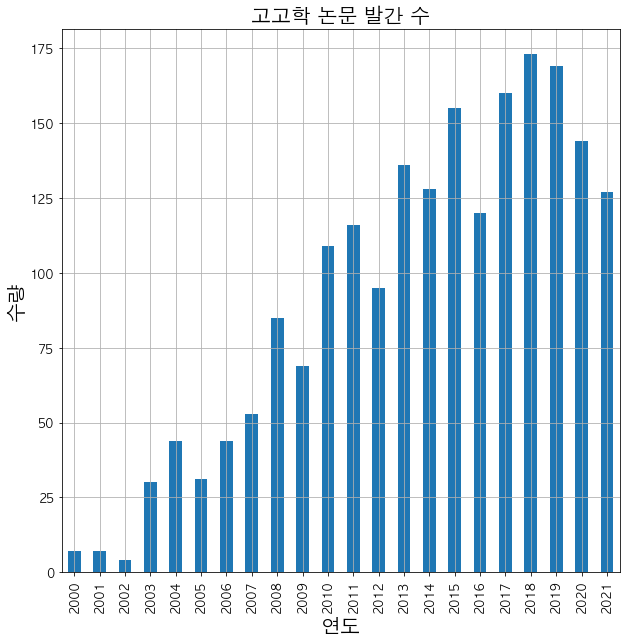

In [72]:
#고고학 논문 발간 수 바 그래프
sort_DB["date"].value_counts().sort_index().plot(kind='bar')
plt.rcParams["figure.figsize"] = (10,10)
plt.title("고고학 논문 발간 수", fontsize=20)
plt.xlabel("연도", fontsize=20)
plt.ylabel("수량", fontsize=20)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid()
plt.show()

---

In [74]:
#Mecab 생성
mecab = Mecab()

#WordCloud 생성
wc = WordCloud(width=1000, height=1000, random_state=0, max_words=50, max_font_size=300 ,background_color="white", font_path=r'./NanumGothicBold.ttf')

In [75]:
#불용어 처리
def clean_text(row):
    text = row['Full-Data']
    txt = re.sub('[a-zA-z]','',text) #영어 제거
    txxt = re.sub('[^가-힣a-z]', ' ', txt)
    text = mecab.morphs(txxt)
    stopwords_path = "./stopword.txt"
    with open(stopwords_path, encoding='UTF-8') as file:
        stopwords = file.readlines()
    stopwords = [x.strip() for x in stopwords]
    text = [t for t in text if t not in stopwords]
    return text

trans_result['Full-Data'] = trans_result.apply(clean_text, axis=1)

In [76]:
#분기별 구분
date_trash = trans_result[trans_result['date'] < 2000] #2000년대 이전

#2000년대 발간 논문
date_zero = trans_result[(trans_result['date'] >= 2000) & (trans_result['date'] < 2010)]
date_zero_nx = trans_result[(trans_result['date'] >= 2000) & (trans_result['date'] < 2010)]
date_zero_title = pd.DataFrame(date_zero['Full-Data'])
date_zero_title.to_csv("./date_zero_title.csv", sep = "\t", index=False)
zero = open("./date_zero_title.csv", 'r', encoding="UTF-8")
data_zero = zero.read()
zero.close()

#2010년대 발간 논문
date_ten = trans_result[(trans_result['date'] >= 2010) & (trans_result['date'] < 2020)]
date_ten_nx = trans_result[(trans_result['date'] >= 2010) & (trans_result['date'] < 2020)] 
date_ten_title = pd.DataFrame(date_ten['Full-Data'])
date_ten_title.to_csv("./date_ten_title.csv", sep = "\t", index=False)
ten = open("./date_ten_title.csv", 'r', encoding="UTF-8")
data_ten = ten.read()
ten.close()

#2020년대 발간 논문
date_twenty = trans_result[trans_result['date'] > 2019]
date_twenty_nx = trans_result[trans_result['date'] > 2019] 
date_twenty_title = pd.DataFrame(date_twenty['Full-Data'])
date_twenty_title.to_csv("./date_twenty_title.csv", sep = "\t", index=False)
twenty = open("./date_twenty_title.csv", 'r', encoding="UTF-8")
data_twenty = twenty.read()
twenty.close()

In [77]:
#발간 논문 명사 빈도 카운트(워드클라우드)
def noun_count(data):
    noun = mecab.nouns(data)
    count = Counter(noun)
    noun_list = count.most_common(50)
    plt.axis("off")
    plt.imshow(wc.generate_from_frequencies(dict(noun_list)))

#네트워크 분석 수행 모듈
def network_analysis(date_nx):
    G = nx.Graph()
    edge_list = []

    for trans_dict in date_nx['Full-Data']:
        trans = list(trans_dict)
        num_trans = len(trans)
        if num_trans > 0 :
            for j in range(num_trans-1):
                for k in range(j+1, num_trans):
                    edge_list += [tuple(sorted([trans[j], trans[k]]))]
    edges = list(Counter(edge_list).items())

    G = nx.Graph((x, y, {'weight': v}) for (x, y), v in edges)

    font_path='./NanumGothicBold.ttf'
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)
    return G

#네트워크 분석 그래프 모듈
def network_graph(G):

    nx.Graph()

    pr = nx.pagerank(G)
    nsize = np.array([v for v in pr.values()])
    nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

    plt.figure(figsize=(80,80))
    pos = nx.kamada_kawai_layout(G)

    font_path='./NanumGothicBold.ttf'
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font_name)

    nx.draw_networkx_nodes(G, pos,
                    node_shape = "o",
                    node_color=range(len(G)),
                    cmap=plt.cm.Blues_r,
                    node_size=25 * nsize)

    nx.draw_networkx_edges(G, pos,
                    style='solid',
                    width=5,
                    alpha=0.1,
                    edge_color='#808080')

    nx.draw_networkx_labels(G, pos,
                    font_size=20,
                    font_family=font_name)
    plt.show()

#연결중심성
def bet_centratlity(data, end):
    bet_cen = nx.betweenness_centrality(data)
    result = sorted(bet_cen.items(), key=lambda x:x[1], reverse=True)[0:end]
    return result

#토픽모델링
def LDA_topic(Topic_data, chunksize, iterations, num_topics, passes, eval_every, year) :
    savename = ('%d' + 'Topic.html') %year
    data_dic = Topic_data.values.tolist()
    dictionary = corpora.Dictionary(data_dic)
    corpus = [dictionary.doc2bow(text) for text in data_dic]
    
    temp = dictionary[0]

    LDA_model = LdaModel(
        corpus=corpus,
        id2word=dictionary.id2token,
        chunksize=chunksize, #트레이닝 1회당 처리할 문서 갯수
        alpha='auto',
        eta='auto',
        iterations=iterations, #문서당 반복 횟수
        num_topics=num_topics,  #생성 토픽 갯수
        passes=passes, #전체 Corpus 트레이닝 횟수
        eval_every=eval_every
    )

    top_topics = LDA_model.top_topics(corpus) #, num_words=20)

    avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
    #print('Average topic coherence: %.4f.' % avg_topic_coherence)
    
    lda_visualization = gensimvis.prepare(LDA_model, corpus, dictionary, sort_topics=False)
    pyLDAvis.save_html(lda_visualization, savename)

---

2022-03-02 13:01:33,438 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-03-02 13:01:33,507 : INFO : built Dictionary(6998 unique tokens: ['가마', '가마터', '갯벌', '거쳐', '겠']...) from 374 documents (total 48519 corpus positions)
2022-03-02 13:01:33,508 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(6998 unique tokens: ['가마', '가마터', '갯벌', '거쳐', '겠']...) from 374 documents (total 48519 corpus positions)", 'datetime': '2022-03-02T13:01:33.508427', 'gensim': '4.1.2', 'python': '3.8.3 (v3.8.3:6f8c8320e9, May 13 2020, 16:29:34) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2022-03-02 13:01:33,559 : INFO : using autotuned alpha, starting with [0.25, 0.25, 0.25, 0.25]
2022-03-02 13:01:33,562 : INFO : using serial LDA version on this node
2022-03-02 13:01:33,569 : INFO : running online (multi-pass) LDA training, 4 topics, 20 passes over the supplied corpus of 374 documents, updating model once every 374 documents, e

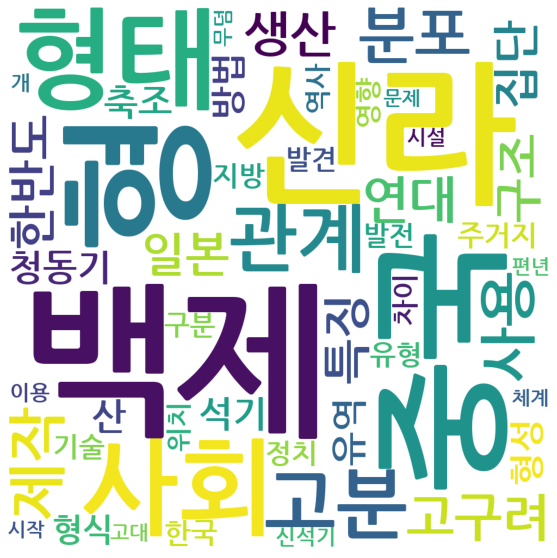

In [78]:
#2000년대 발간 학술 논문 분석
#워드클라우드 출력
noun_count(data_zero)

#토픽모델링 출력
LDA_topic(date_zero["Full-Data"], chunksize=20000, iterations=400, num_topics=4, passes=20, eval_every=None, year=2000)

2022-03-02 13:01:59,928 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-03-02 13:02:00,573 : INFO : built Dictionary(14379 unique tokens: ['가야', '가치', '강압', '강점기', '견지']...) from 1361 documents (total 206979 corpus positions)
2022-03-02 13:02:00,575 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(14379 unique tokens: ['가야', '가치', '강압', '강점기', '견지']...) from 1361 documents (total 206979 corpus positions)", 'datetime': '2022-03-02T13:02:00.575223', 'gensim': '4.1.2', 'python': '3.8.3 (v3.8.3:6f8c8320e9, May 13 2020, 16:29:34) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2022-03-02 13:02:00,944 : INFO : using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]
2022-03-02 13:02:00,953 : INFO : using serial LDA version on this node
2022-03-02 13:02:00,974 : INFO : running online (multi-pass) LDA training, 5 topics, 20 passes over the supplied corpus of 1361 documents, updating model once every 1361 d

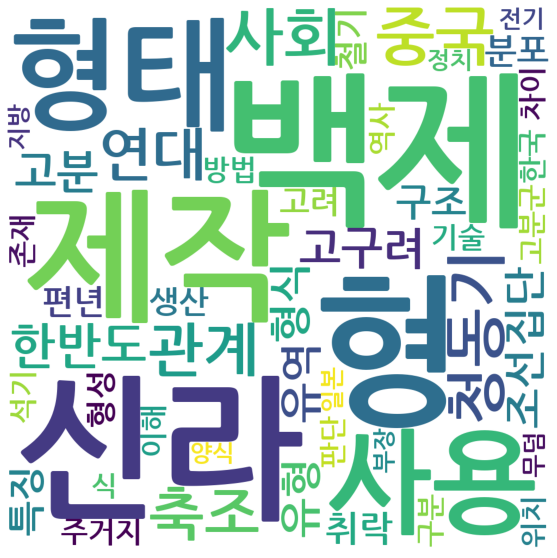

In [79]:
#2010년대 발간 학술 논문 분석
#워드클라우드 출력
noun_count(data_ten)

#토픽모델링 출력
LDA_topic(date_ten["Full-Data"], chunksize=20000, iterations=400, num_topics=5, passes=20, eval_every=None, year=2010)

2022-03-02 13:02:38,850 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-03-02 13:02:38,912 : INFO : built Dictionary(6746 unique tokens: ['간', '강한', '고총', '곳', '그곳']...) from 271 documents (total 43154 corpus positions)
2022-03-02 13:02:38,913 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(6746 unique tokens: ['간', '강한', '고총', '곳', '그곳']...) from 271 documents (total 43154 corpus positions)", 'datetime': '2022-03-02T13:02:38.913621', 'gensim': '4.1.2', 'python': '3.8.3 (v3.8.3:6f8c8320e9, May 13 2020, 16:29:34) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2022-03-02 13:02:38,953 : INFO : using autotuned alpha, starting with [0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667]
2022-03-02 13:02:38,956 : INFO : using serial LDA version on this node
2022-03-02 13:02:38,962 : INFO : running online (multi-pass) LDA training, 6 topics, 20 passes over the supplied corpus of 271 documents

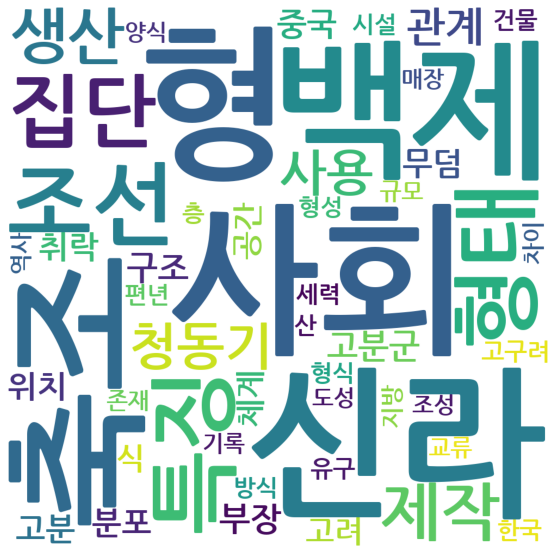

In [80]:
#2020년대 발간 학술 논문 분석
#워드클라우드 출력
noun_count(data_twenty)

#토픽모델링 출력
LDA_topic(date_twenty["Full-Data"], chunksize=20000, iterations=400, num_topics=6, passes=20, eval_every=None, year=2020)